# MVP - Engenharia de Dados
## Autor: Marcel Antonio Lopes Pereira
## Curso: Ciência de Dados & Analytics - PUC-RJ

## 5. Análise e solução do problema

Com a camada gold devidamente estruturada, pode-se responder às perguntas propostas sobre a dominância das seleções nacionais ao longo da história do futebol. A camada foi construída para oferecer uma visão consolidada e de fácil acesso aos dados, garantindo que possamos explorar estatísticas detalhadas sobre desempenho das equipes, evolução no ranking da FIFA e impacto dos torneios ao longo do tempo.

As perguntas respondidas abrangeram diversos aspectos da performance das seleções, incluindo vitórias, histórico de confrontos, impacto do ranking FIFA nos resultados e outros fatores relevantes. Utilizando consultas SQL, extrairemos insights que nos permitirão entender melhor quais seleções demonstraram maior domínio ao longo da história.

A seguir, cada pergunta foi respondida com uma abordagem detalhada, utilizando as tabelas da camada gold. As respostas foram complementadas com visualizações para tornar os insights mais intuitivos.

In [0]:
# Importando bibliotecas necessárias para o projeto
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Importação de funções do Spark
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

Foram definidas funções para construção de alguns gráficos.

In [0]:
def plot_horizontal_bars(
    dfs,
    titles,
    value_cols,
    labels=None,
    palettes=None,
    xlabel="Valor",
    figsize=(14, 20),
    label_format_func=None
):
    """
    Gera gráficos de barras horizontais para múltiplos DataFrames.

    Parâmetros:
    - dfs: lista de DataFrames do pandas
    - titles: lista de títulos dos gráficos
    - value_cols: lista com os nomes das colunas numéricas (valores das barras)
    - labels: lista de nomes das colunas de rótulo (opcional)
    - palettes: lista com paletas de cores seaborn (opcional)
    - xlabel: nome do eixo X
    - figsize: tamanho da figura
    - label_format_func: função opcional para formatar o texto exibido nas barras
    """
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(len(dfs), 1, figsize=figsize)

    if palettes is None:
        palettes = ["Blues_d", "Greens_d", "Oranges_d"] * len(dfs)

    for i, (df, title, value_col) in enumerate(zip(dfs, titles, value_cols)):
        ax = axs[i]
        palette = palettes[i]
        label_col = labels[i] if labels else value_col

        sns.barplot(
            ax=ax,
            data=df,
            y="team",
            x=value_col,
            palette=palette
        )

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Seleção" if i == 0 else "")

        for j, row in df.iterrows():
            label_text = (
                label_format_func(row) if label_format_func
                else str(row[label_col])
            )
            ax.text(
                row[value_col] - (0.03 if df[value_col].max() <= 3 else 3),
                j,
                label_text,
                color="white",
                va="center",
                ha="right",
                fontsize=12,
                fontweight="bold"
            )

    plt.tight_layout()
    plt.show()


In [0]:
def plot_horizontal_graph(
    df,
    x_col,
    y_col,
    label_col,
    title,
    xlabel,
    ylabel,
    palette,
    figsize
):
    """
    Gera um gráfico de barras horizontais com os valores destacados.

    Parâmetros:
    - df: DataFrame Pandas com os dados.
    - x_col: nome da coluna de valores para o eixo x.
    - y_col: nome da coluna com as categorias (seleções).
    - label_col: coluna com os valores a serem exibidos nas barras.
    - title: título do gráfico.
    - xlabel: rótulo do eixo x.
    - ylabel: rótulo do eixo y.
    - palette: paleta de cores do seaborn.
    - figsize: tupla com o tamanho da figura (largura, altura).
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)

    barplot = sns.barplot(
        data=df,
        y=y_col,
        x=x_col,
        palette=palette
    )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for index, row in df.iterrows():
        barplot.text(
            row[x_col] - max(df[x_col]) * 0.015,
            index,
            str(row[label_col]),
            color="white",
            ha='right',
            va='center',
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()


### 5.1 **Qual seleção tem o maior número de vitórias em jogos oficiais e amistosos?**  
A fim de destacar as seleções mais vitoriosas, cada consulta foi estruturada para listar os 10 países com o maior número de vitórias. Essa abordagem permite identificar as equipes com maior consistência histórica, tanto em um contexto geral quanto separadamente para jogos oficiais e amistosos. Ao segmentar os resultados dessa forma, é possível evidenciar quais seleções dominaram diferentes tipos de competições ao longo do tempo.

A seguir, foi executado um sript que carregou dataframes a partir das consultas SQL e na sequência construiu os gráficos a partir dos respectivos dataframes.

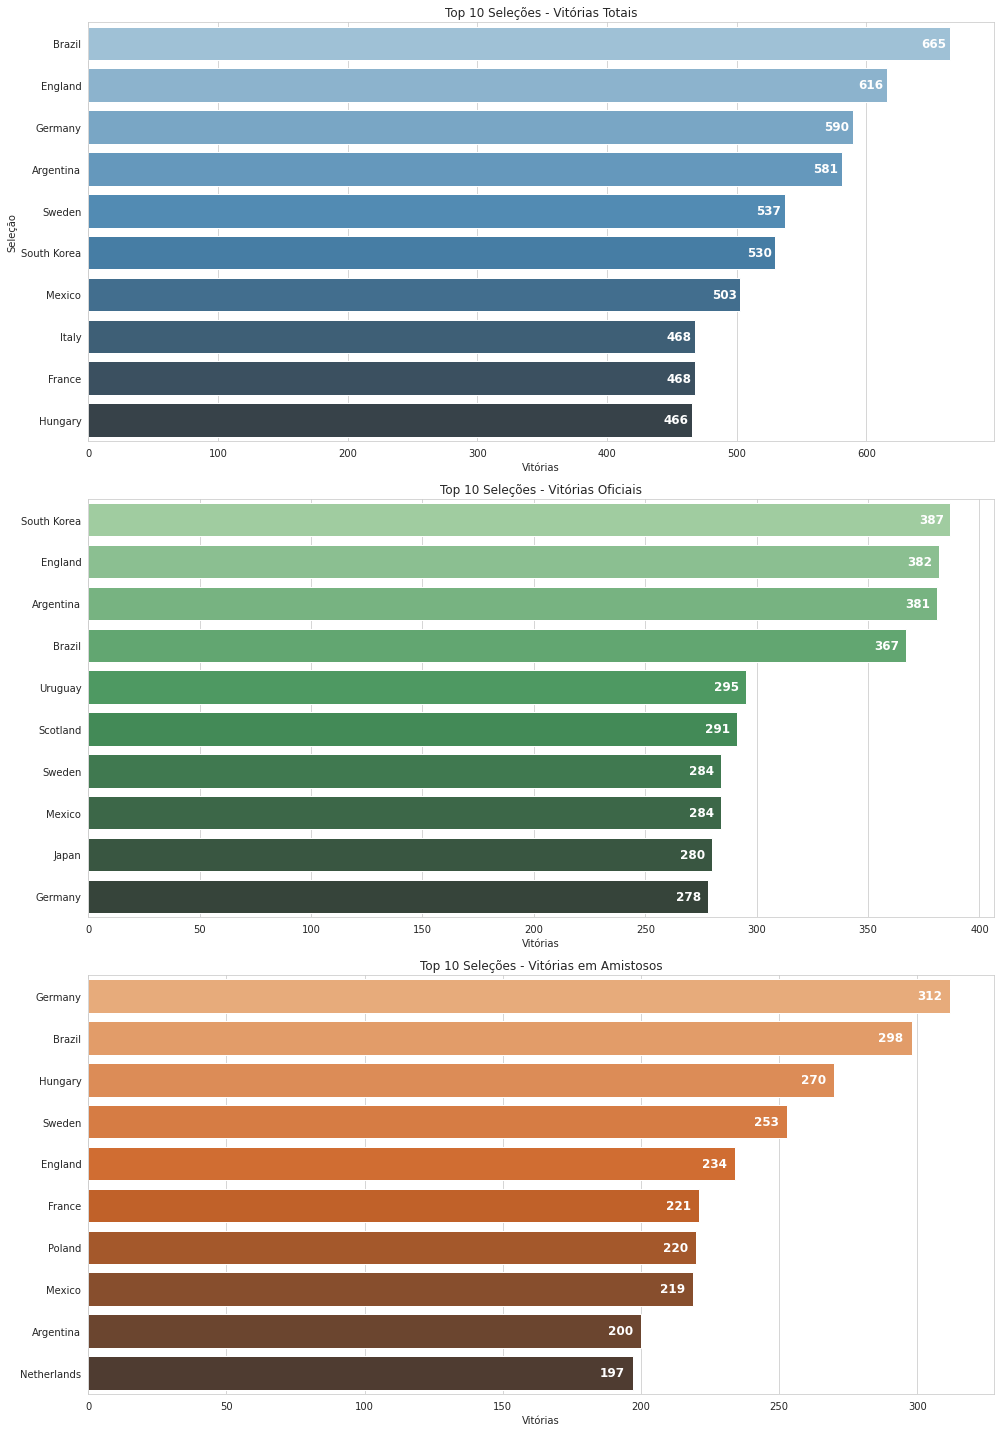

In [0]:
# Top 10 seleções com mais vitórias totais
df_total_wins = spark.sql("""
    SELECT team, COUNT(*) AS total_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score

        UNION ALL

        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score
    ) AS victories
    GROUP BY team
    ORDER BY total_wins DESC
    LIMIT 10
""")

# Top 10 seleções com mais vitórias em jogos oficiais
df_official_wins = spark.sql("""
    SELECT team, COUNT(*) AS official_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score
          AND tournament != 'Friendly'

        UNION ALL

        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score
          AND tournament != 'Friendly'
    ) AS official_victories
    GROUP BY team
    ORDER BY official_wins DESC
    LIMIT 10
""")

# Top 10 seleções com mais vitórias em amistosos
df_friendly_wins = spark.sql("""
    SELECT team, COUNT(*) AS friendly_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score
          AND tournament = 'Friendly'

        UNION ALL

        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score
          AND tournament = 'Friendly'
    ) AS friendly_victories
    GROUP BY team
    ORDER BY friendly_wins DESC
    LIMIT 10
""")

# Conversão para pandas
pdf_total_wins = df_total_wins.toPandas()
pdf_official_wins = df_official_wins.toPandas()
pdf_friendly_wins = df_friendly_wins.toPandas()

plot_horizontal_bars(
    dfs=[pdf_total_wins, pdf_official_wins, pdf_friendly_wins],
    titles=[
        "Top 10 Seleções - Vitórias Totais",
        "Top 10 Seleções - Vitórias Oficiais",
        "Top 10 Seleções - Vitórias em Amistosos"
    ],
    value_cols=["total_wins", "official_wins", "friendly_wins"],
    palettes=["Blues_d", "Greens_d", "Oranges_d"],
    xlabel="Vitórias"
)


#### Destaques:
A análise apresenta as 10 seleções mais vitoriosas da história do futebol internacional, considerando **todos os tipos de jogos**, bem como uma separação entre **competições oficiais** e **amistosos**.

- Vitórias Totais:
O **Brasil** lidera o ranking geral de vitórias, refletindo sua tradição vencedora ao longo das décadas. Logo atrás estão **Inglaterra**, **Alemanha** e **Argentina** — seleções historicamente fortes em ambos os cenários (amistosos e competições oficiais). O destaque vai também para a **Suécia** e a **Coreia do Sul**, que mostram consistência em número absoluto de triunfos.

-  Vitórias em Jogos Oficiais:
Neste recorte, a liderança é ocupada pela **Coreia do Sul**, com um número elevado de vitórias em competições oficiais, o que reflete sua frequência em torneios continentais e classificatórias asiáticas. Em seguida, aparecem **Inglaterra**, **Argentina** e **Brasil**, todos com campanhas sólidas em Copas do Mundo, Eliminatórias e torneios continentais. O **Uruguai** e a **Escócia** também se destacam por sua performance histórica.

- Vitórias em Amistosos:
A **Alemanha** aparece como a seleção com maior número de vitórias em amistosos, seguida de perto por **Brasil** e **Hungria**. Isso indica não apenas tradição, mas também uma alta frequência de jogos amistosos disputados. Outros destaques incluem **Suécia**, **França** e **Polônia**, que acumulam muitos triunfos em partidas preparatórias ao longo da história.

**Considerações:**

Ao separar os contextos dos jogos, percebemos que algumas seleções mantêm alta performance tanto em amistosos quanto em jogos oficiais (**Brasil**, **Argentina** e **Inglaterra**), enquanto outras se sobressaem em um dos dois cenários. Isso mostra não apenas a tradição futebolística, mas também a frequência com que essas seleções participam de jogos internacionais e sua regularidade em competições.


### 5.2. **Qual seleção tem a melhor taxa de aproveitamento (pontos ganhos por jogo)?**
Para garantir uma análise detalhada e comparável ao longo da história, as consultas SQL calcularam a taxa de aproveitamento das seleções em três cenários distintos: todas as partidas, apenas jogos oficiais e exclusivamente amistosos. A eficiência das equipes foi medida pela média de pontos conquistados por jogo, adotando um critério unificado de pontuação (3 pontos por vitória, 1 por empate e 0 por derrota), padronizando diferentes períodos e formatos de torneios. Além disso, para assegurar que os rankings refletissem um desempenho consistente, apenas seleções com pelo menos 100 partidas disputadas foram consideradas, evitando distorções causadas por amostras pequenas e permitindo uma comparação mais fiel entre os diferentes contextos competitivos.

A seguir, foi executado um sript que carregou dataframes a partir das consultas SQL e na sequência construiu os gráficos a partir dos respectivos dataframes.

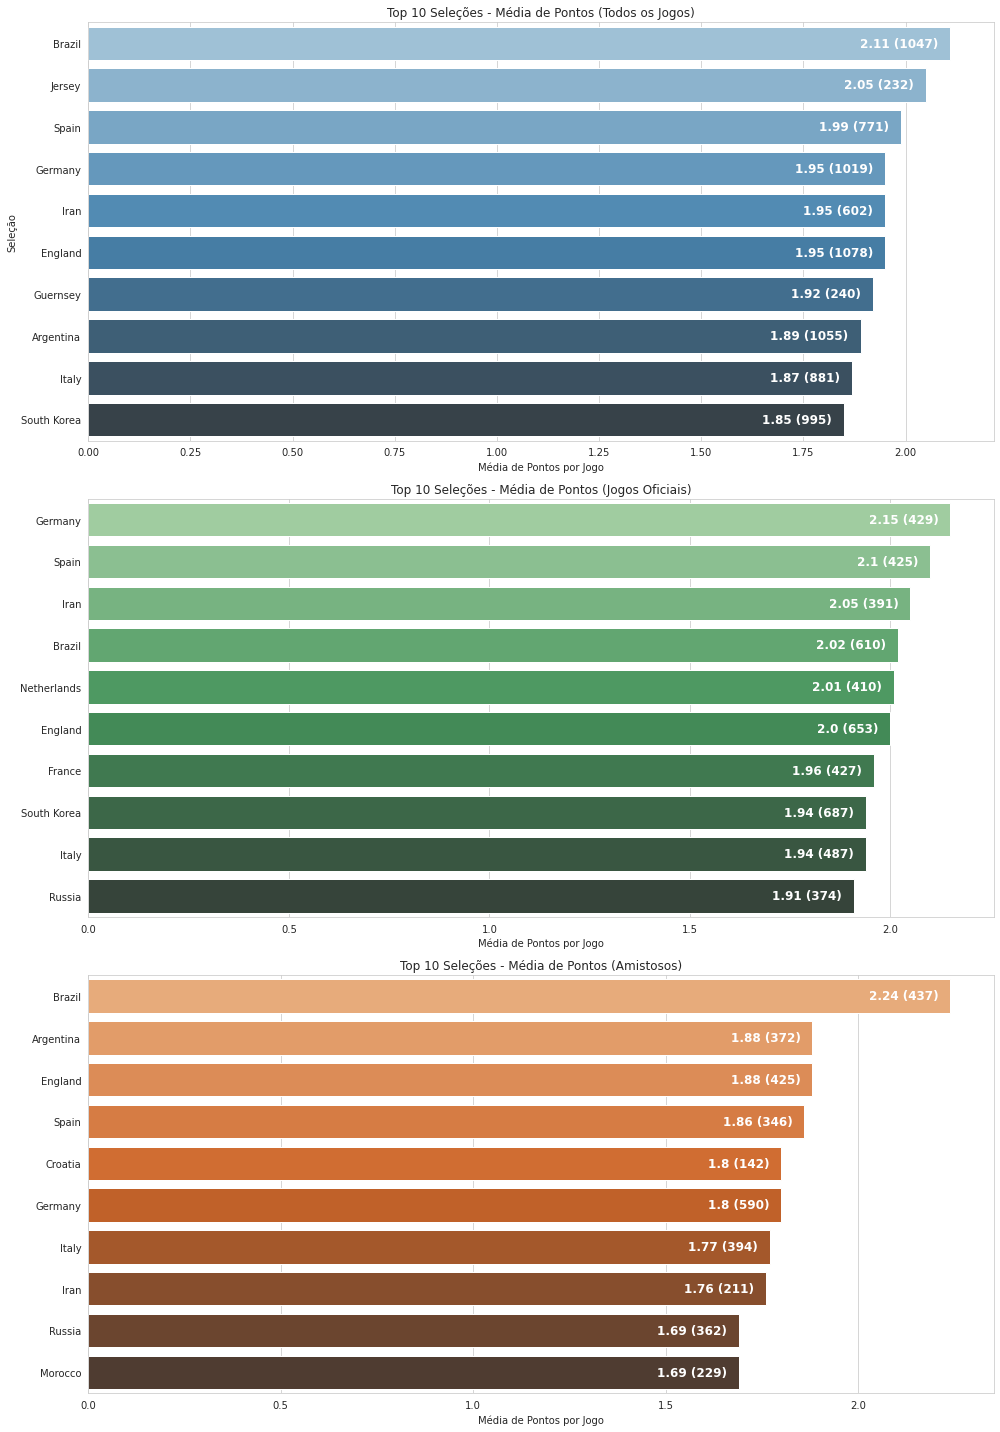

In [0]:
# Executa as consultas SQL e converte os resultados para Pandas
df_geral = spark.sql("""
SELECT 
    team,
    ROUND(SUM(points) / COUNT(match_id), 2) AS avg_points_per_game,
    COUNT(match_id) AS total_games
FROM (
    SELECT 
        home_team AS team,
        match_id,
        CASE 
            WHEN home_score > away_score THEN 3
            WHEN home_score = away_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance

    UNION ALL

    SELECT 
        away_team AS team,
        match_id,
        CASE 
            WHEN away_score > home_score THEN 3
            WHEN away_score = home_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance
) AS all_matches
GROUP BY team
HAVING COUNT(match_id) >= 100
ORDER BY avg_points_per_game DESC
LIMIT 10
""").toPandas()

df_oficial = spark.sql("""
SELECT 
    team,
    ROUND(SUM(points) / COUNT(match_id), 2) AS avg_points_per_game,
    COUNT(match_id) AS total_games
FROM (
    SELECT 
        home_team AS team,
        match_id,
        CASE 
            WHEN home_score > away_score THEN 3
            WHEN home_score = away_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance
    WHERE tournament != 'Friendly'

    UNION ALL

    SELECT 
        away_team AS team,
        match_id,
        CASE 
            WHEN away_score > home_score THEN 3
            WHEN away_score = home_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance
    WHERE tournament != 'Friendly'
) AS official_matches
GROUP BY team
HAVING COUNT(match_id) >= 300
ORDER BY avg_points_per_game DESC
LIMIT 10
""").toPandas()

df_amistoso = spark.sql("""
SELECT 
    team,
    ROUND(SUM(points) / COUNT(match_id), 2) AS avg_points_per_game,
    COUNT(match_id) AS total_games
FROM (
    SELECT 
        home_team AS team,
        match_id,
        CASE 
            WHEN home_score > away_score THEN 3
            WHEN home_score = away_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance
    WHERE tournament = 'Friendly'

    UNION ALL

    SELECT 
        away_team AS team,
        match_id,
        CASE 
            WHEN away_score > home_score THEN 3
            WHEN away_score = home_score THEN 1 
            ELSE 0 
        END AS points
    FROM gold.match_performance
    WHERE tournament = 'Friendly'
) AS friendly_matches
GROUP BY team
HAVING COUNT(match_id) >= 100
ORDER BY avg_points_per_game DESC
LIMIT 10
""").toPandas()

# Cria rótulo personalizado com média + total de jogos
for df in [df_geral, df_oficial, df_amistoso]:
    df["label"] = (
        df["avg_points_per_game"].round(2).astype(str) +
        " (" + df["total_games"].astype(str) + ")"
    )

plot_horizontal_bars(
    dfs=[df_geral, df_oficial, df_amistoso],
    titles=[
        "Top 10 Seleções - Média de Pontos (Todos os Jogos)",
        "Top 10 Seleções - Média de Pontos (Jogos Oficiais)",
        "Top 10 Seleções - Média de Pontos (Amistosos)"
    ],
    value_cols=["avg_points_per_game"] * 3,
    labels=["label"] * 3,
    palettes=["Blues_d", "Greens_d", "Oranges_d"],
    xlabel="Média de Pontos por Jogo"
)


#### Destaques:
Para medir a eficiência histórica das seleções, foi calculada a média de pontos conquistados por jogo (3 pontos por vitória, 1 por empate e 0 por derrota), considerando três cenários distintos: todas as partidas, apenas jogos oficiais e apenas amistosos. Seleções com menos de 100 jogos foram filtradas para garantir maior confiabilidade na análise.

Os destaques observados foram:

- **Brasil** lidera o ranking geral com **2,11 pontos por jogo** em mais de 1.000 partidas, mostrando sua regularidade histórica.
- **Jersey** e **Guernsey** possuem médias altas, mas com número reduzido de jogos — o que exige cautela na interpretação.
- Em **jogos oficiais**, **Alemanha** se destaca com **2,15 pontos por jogo**, seguida por **Espanha** e **Irã**.
- Nos **amistosos**, o Brasil volta a liderar com **2,24 pontos por partida**, refletindo sua consistência também em contextos menos competitivos.

Esses resultados reforçam o domínio de seleções como **Brasil**, **Alemanha**, **Espanha** e **Inglaterra** em diferentes contextos, além de evidenciar como o desempenho pode variar entre competições formais e partidas amistosas.


### 5.3. **Qual seleção tem o maior saldo de gols (gols marcados - gols sofridos) em toda a história?** 
O saldo de gols — diferença entre gols marcados e sofridos — é um indicador essencial para avaliar a força histórica das seleções, refletindo tanto sua capacidade ofensiva quanto a solidez defensiva. Para esta análise, foi calculado o saldo acumulado de cada seleção ao longo do tempo, considerando três cenários distintos: todas as partidas, apenas jogos oficiais e exclusivamente amistosos.

Essa abordagem permitiu identificar equipes que, além de vencerem com frequência, conseguiram manter um padrão de desempenho equilibrado entre ataque e defesa. Como medida de confiabilidade, apenas seleções que tenham disputado pelo menos 100 partidas foram consideradas, evitando distorções causadas por amostras pequenas e garantindo uma análise comparativa mais justa entre os países.

A seguir, foi executado um sript que carregou dataframes a partir das consultas SQL e na sequência construiu os gráficos a partir dos respectivos dataframes.

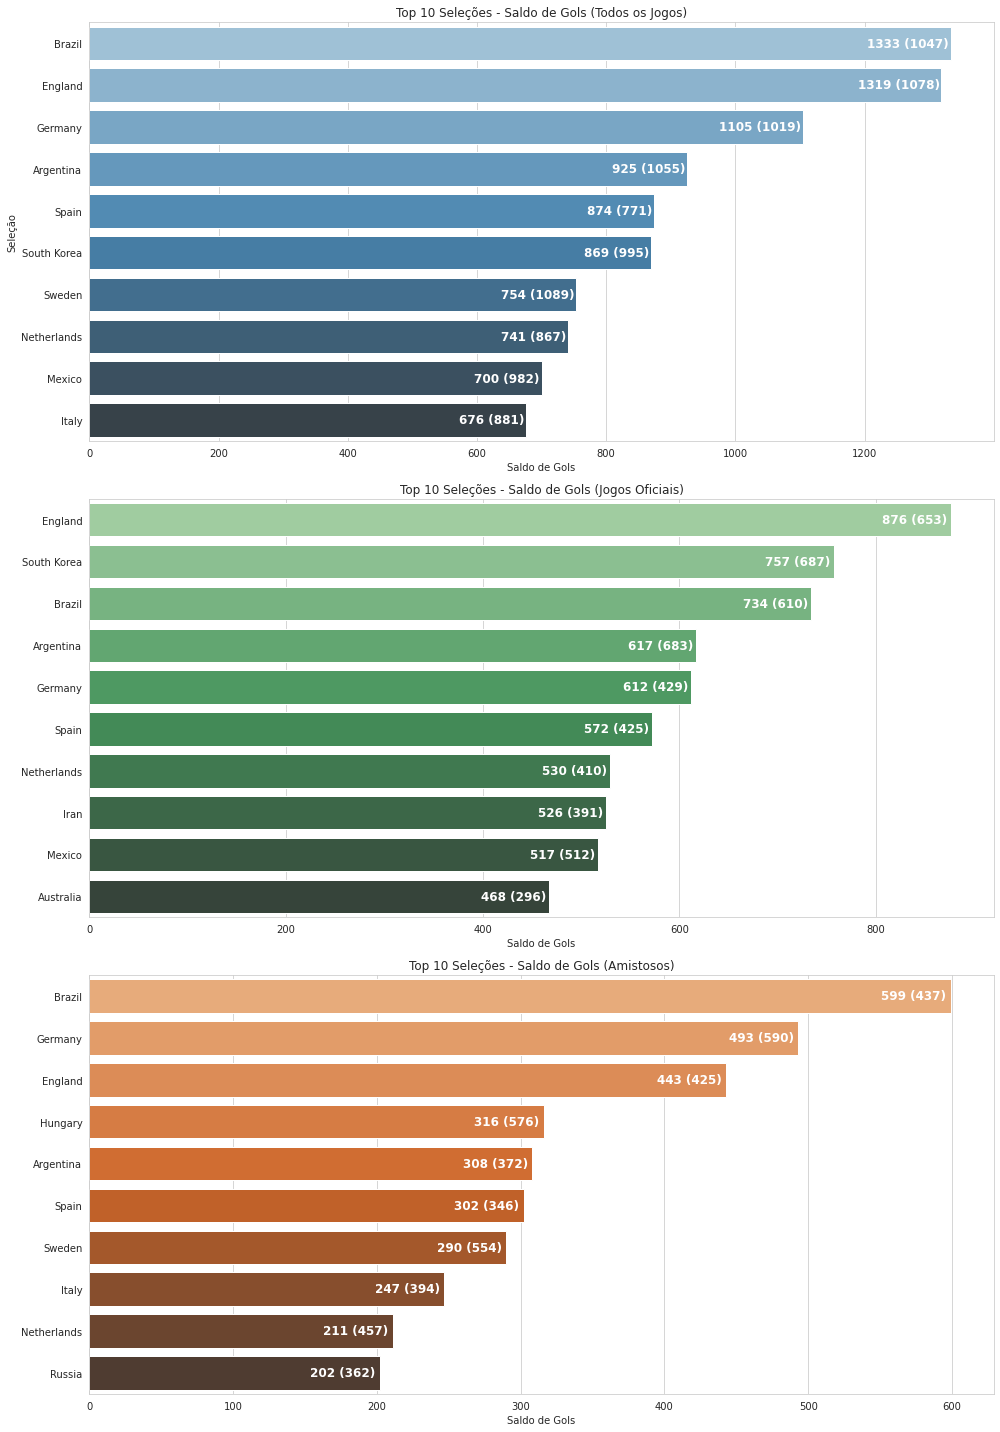

In [0]:
# Consulta: Saldo de gols - Todos os jogos
df_total_goal_diff = spark.sql("""
SELECT team,
       SUM(goals_scored) - SUM(goals_conceded) AS goal_difference,
       COUNT(*) AS total_matches
FROM (
    SELECT home_team AS team, 
           home_score AS goals_scored, 
           away_score AS goals_conceded
    FROM gold.match_performance
    UNION ALL
    SELECT away_team AS team, 
           away_score AS goals_scored, 
           home_score AS goals_conceded
    FROM gold.match_performance
) match_data
GROUP BY team
HAVING COUNT(*) >= 100
ORDER BY goal_difference DESC
LIMIT 10
""")

# Consulta: Saldo de gols - Apenas jogos oficiais
df_official_goal_diff = spark.sql("""
SELECT team,
       SUM(goals_scored) - SUM(goals_conceded) AS goal_difference,
       COUNT(*) AS total_matches
FROM (
    SELECT home_team AS team, 
           home_score AS goals_scored, 
           away_score AS goals_conceded
    FROM gold.match_performance
    WHERE tournament NOT LIKE 'Friendly%'
    UNION ALL
    SELECT away_team AS team, 
           away_score AS goals_scored, 
           home_score AS goals_conceded
    FROM gold.match_performance
    WHERE tournament NOT LIKE 'Friendly%'
) match_data
GROUP BY team
HAVING COUNT(*) >= 100
ORDER BY goal_difference DESC
LIMIT 10
""")

# Consulta: Saldo de gols - Apenas amistosos
df_friendly_goal_diff = spark.sql("""
SELECT team,
       SUM(goals_scored) - SUM(goals_conceded) AS goal_difference,
       COUNT(*) AS total_matches
FROM (
    SELECT home_team AS team, 
           home_score AS goals_scored, 
           away_score AS goals_conceded
    FROM gold.match_performance
    WHERE tournament LIKE 'Friendly%'
    UNION ALL
    SELECT away_team AS team, 
           away_score AS goals_scored, 
           home_score AS goals_conceded
    FROM gold.match_performance
    WHERE tournament LIKE 'Friendly%'
) match_data
GROUP BY team
HAVING COUNT(*) >= 100
ORDER BY goal_difference DESC
LIMIT 10
""")

# Conversão dos DataFrames Spark para Pandas
pdf_total_goal_diff = df_total_goal_diff.toPandas()
pdf_official_goal_diff = df_official_goal_diff.toPandas()
pdf_friendly_goal_diff = df_friendly_goal_diff.toPandas()

# Criação dos rótulos para exibir o saldo e o total de jogos
for df in [pdf_total_goal_diff, pdf_official_goal_diff, pdf_friendly_goal_diff]:
    df["label"] = df["goal_difference"].astype(int).astype(str) + \
                  " (" + df["total_matches"].astype(int).astype(str) + ")"

# Uso da função genérica para os gráficos
plot_horizontal_bars(
    dfs=[
        pdf_total_goal_diff,
        pdf_official_goal_diff,
        pdf_friendly_goal_diff
    ],
    titles=[
        "Top 10 Seleções - Saldo de Gols (Todos os Jogos)",
        "Top 10 Seleções - Saldo de Gols (Jogos Oficiais)",
        "Top 10 Seleções - Saldo de Gols (Amistosos)"
    ],
    value_cols=["goal_difference"] * 3,
    labels=["label"] * 3,
    palettes=["Blues_d", "Greens_d", "Oranges_d"],
    xlabel="Saldo de Gols"
)

Para avaliar o desempenho ofensivo e defensivo das seleções ao longo da história, foi analisado o **saldo de gols absoluto** — diferença entre gols marcados e sofridos — em três contextos distintos: todas as partidas, apenas jogos oficiais e apenas amistosos.

Optou-se por utilizar o valor **absoluto**, e não a média por jogo, para evitar distorções causadas por seleções com poucos confrontos, garantindo uma métrica mais representativa do impacto histórico das equipes.

**Principais destaques:**

- **Brasil** lidera o ranking geral com um saldo de **1.333 gols**, refletindo sua superioridade histórica tanto no ataque quanto na defesa. A constância em diversas gerações e competições consolida sua imagem como uma das seleções mais dominantes do futebol mundial.

- Em **jogos oficiais**, a **Inglaterra** assume a liderança com **876 gols de saldo**, o que surpreende positivamente e destaca sua regularidade em competições formais, especialmente considerando seu histórico consistente nas Eliminatórias e Eurocopas.

- A **Coreia do Sul** aparece em segundo lugar nesse recorte, com **757 gols de saldo**, evidenciando sua trajetória sólida no cenário asiático e sua constância em torneios continentais e classificatórios.

- O **Brasil**, mesmo em terceiro lugar nesse critério (**734 gols**), mantém presença no topo, mostrando que além dos amistosos, seu desempenho também é expressivo em torneios oficiais.

- Nos **amistosos**, o **Brasil** volta ao topo com ampla vantagem, acumulando **599 gols de saldo**, o que demonstra não apenas sua força técnica, mas também sua tradição em confrontos internacionais mesmo fora de contextos competitivos. Seleções como **Alemanha** e **Argentina** também se destacam nesse cenário, reforçando o peso de suas trajetórias históricas.

Esses resultados evidenciam o protagonismo de seleções tradicionais em diferentes contextos competitivos, destacando sua capacidade de impor vantagem sobre os adversários tanto em torneios formais quanto em partidas preparatórias. Além disso, mostram como algumas seleções, mesmo fora do eixo europeu-sul-americano, têm construído relevância regional e histórica com consistência.



### 5.4. **Qual seleção tem o maior número de vitórias contra outras grandes seleções (top 10 do ranking da FIFA)?**

Para avaliar a competitividade das seleções contra a elite do futebol mundial, foi analisado o número de vitórias conquistadas contra adversários que figuravam entre os 10 primeiros colocados do ranking da FIFA na data da partida. Como o ranking passou a ser oficialmente computado a partir de 1992, a análise se restringe a confrontos realizados a partir desse ano, garantindo um critério padronizado e reconhecido internacionalmente para definir a força dos oponentes.

Com o objetivo de oferecer uma visão mais detalhada, os resultados foram segmentados em três categorias distintas:  
1. **Todas as partidas**,  
2. **Apenas jogos oficiais**,  
3. **Somente amistosos**.

Essa abordagem permite comparar o desempenho das seleções em diferentes contextos competitivos e identificar quais equipes se sobressaem em confrontos diretos contra adversários de alto nível, considerando tanto torneios formais quanto jogos preparatórios.



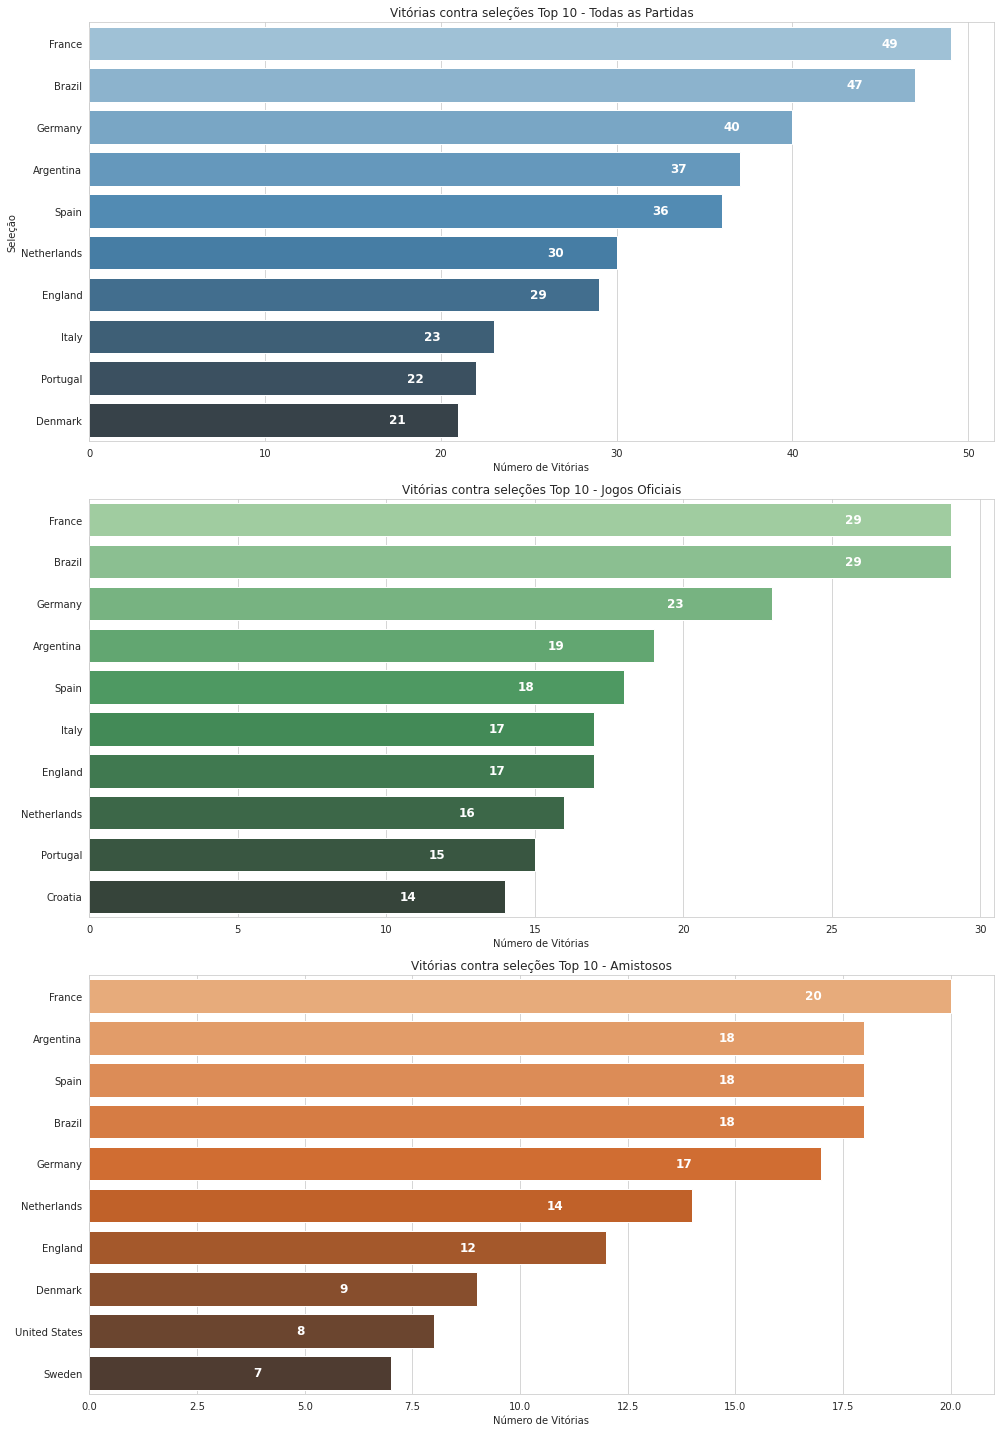

In [0]:
# Consultas SQL e conversão dos dados de vitórias contra seleções Top 10 para Pandas

# --- Todas as partidas
df_top10_all = spark.sql("""
    SELECT team, COUNT(*) AS total_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score AND away_team_rank <= 10
        UNION ALL
        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score AND home_team_rank <= 10
    ) AS victories
    GROUP BY team
    ORDER BY total_wins DESC
    LIMIT 10
""")
pdf_top10_all = df_top10_all.toPandas()

# --- Jogos oficiais
df_top10_official = spark.sql("""
    SELECT team, COUNT(*) AS official_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score AND away_team_rank <= 10
              AND tournament <> 'Friendly'
        UNION ALL
        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score AND home_team_rank <= 10
              AND tournament <> 'Friendly'
    ) AS official_victories
    GROUP BY team
    ORDER BY official_wins DESC
    LIMIT 10
""")
pdf_top10_official = df_top10_official.toPandas()

# --- Amistosos
df_top10_friendly = spark.sql("""
    SELECT team, COUNT(*) AS friendly_wins
    FROM (
        SELECT home_team AS team
        FROM gold.match_performance
        WHERE home_score > away_score AND away_team_rank <= 10
              AND tournament = 'Friendly'
        UNION ALL
        SELECT away_team AS team
        FROM gold.match_performance
        WHERE away_score > home_score AND home_team_rank <= 10
              AND tournament = 'Friendly'
    ) AS friendly_victories
    GROUP BY team
    ORDER BY friendly_wins DESC
    LIMIT 10
""")
pdf_top10_friendly = df_top10_friendly.toPandas()

# Aplicação da função genérica para os gráficos
plot_horizontal_bars(
    dfs=[
        pdf_top10_all,
        pdf_top10_official,
        pdf_top10_friendly
    ],
    titles=[
        "Vitórias contra seleções Top 10 - Todas as Partidas",
        "Vitórias contra seleções Top 10 - Jogos Oficiais",
        "Vitórias contra seleções Top 10 - Amistosos"
    ],
    value_cols=["total_wins", "official_wins", "friendly_wins"],
    labels=["total_wins", "official_wins", "friendly_wins"],
    palettes=["Blues_d", "Greens_d", "Oranges_d"],
    xlabel="Número de Vitórias"
)

**Destaques**:

Os resultados desta análise revelaram que **França**, **Brasil** e **Alemanha** lideraram em número de vitórias contra seleções que ocupavam o **Top 10 do ranking da FIFA**, reforçando suas posições como **potências históricas do futebol moderno**.

- A **França** se destacou como a seleção com **mais vitórias no geral**, mantendo um desempenho consistente tanto em **competições oficiais** quanto em **amistosos**.
- O **Brasil**, tradicionalmente uma das equipes mais dominantes do futebol mundial, apareceu em **segundo lugar**, demonstrando **equilíbrio entre torneios oficiais e partidas amistosas**.
- A **Alemanha**, conhecida por sua **consistência e competitividade**, também figurou entre as três primeiras, consolidando-se como uma equipe capaz de **superar adversários de elite**.

Com a segmentação dos jogos, variações interessantes foram notadas:

- Nos **jogos oficiais**, **França** e **Brasil** seguiram no topo, evidenciando sua capacidade de se impor contra adversários fortes em contextos de **alta competitividade**.
- Já nos **amistosos**, **Argentina** e **Espanha** apresentaram **bons desempenhos**, possivelmente aproveitando esse tipo de confronto para testar **elencos competitivos**.

Essas diferenças mostraram que, embora algumas seleções tenham mantido alta performance independentemente do contexto, **outras tenderam a ter variações de desempenho conforme a natureza do confronto**.


### 5.5. **Qual seleção tem a maior sequência invicta em toda a história?**  
Ao longo da história do futebol, algumas seleções conseguiram manter longas sequências invictas, demonstrando consistência, resiliência e domínio sobre seus adversários.
Essas séries invictas podem ocorrer tanto em torneios oficiais quanto em amistosos, mas, independentemente do contexto, refletem a capacidade de uma equipe em sustentar um alto nível de desempenho ao longo do tempo.

Para identificar as maiores sequências, foi analisado o histórico de jogos de cada seleção e foram destacadas as maiores séries consecutivas de partidas sem derrotas — considerando vitórias e empates.

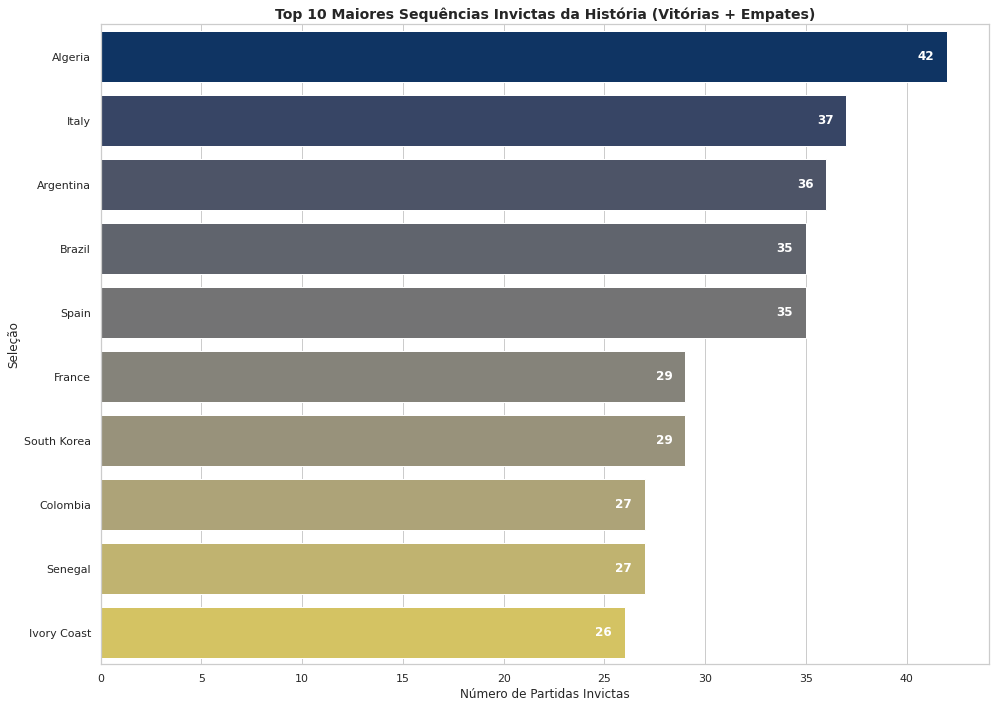

Seleção,Sequência Invicta,Data Inicial,Data Final
Algeria,42,2018-11-18,2022-01-11
Italy,37,2018-10-10,2021-09-08
Argentina,36,2019-07-06,2022-11-16
Brazil,35,1993-12-16,1996-01-18
Spain,35,2007-02-07,2009-06-20
France,29,1994-02-16,1996-10-09
South Korea,29,1977-09-03,1978-12-29
Colombia,27,2022-03-24,2024-07-10
Senegal,27,2015-11-13,2018-05-31
Ivory Coast,26,2011-02-08,2013-01-30


In [0]:
# Criação da visão temporária no SQL
spark.sql("""
    CREATE OR REPLACE TEMP VIEW match_result_per_team AS
    SELECT 
        match_id,
        match_date,
        home_team AS team,
        away_team AS opponent,
        home_score AS team_score,
        away_score AS opponent_score,
        home_team_rank AS team_rank,
        away_team_rank AS opponent_rank,
        tournament,
        is_neutral,
        'Home' AS home_away,
        CASE 
            WHEN home_score > away_score THEN 'W'
            WHEN home_score = away_score THEN 'D'
            ELSE 'L'
        END AS result
    FROM gold.match_performance

    UNION ALL

    SELECT 
        match_id,
        match_date,
        away_team AS team,
        home_team AS opponent,
        away_score AS team_score,
        home_score AS opponent_score,
        away_team_rank AS team_rank,
        home_team_rank AS opponent_rank,
        tournament,
        is_neutral,
        'Away' AS home_away,
        CASE 
            WHEN away_score > home_score THEN 'W'
            WHEN away_score = home_score THEN 'D'
            ELSE 'L'
        END AS result
    FROM gold.match_performance
""")

# Carrega a visão temporária como DataFrame
df = spark.sql("SELECT * FROM match_result_per_team")

# Coluna que identifica se o time está invicto no jogo
df = df.withColumn(
    "is_unbeaten", 
    F.when(F.col("result").isin("W", "D"), 1).otherwise(0)
)

# Criação de janela por seleção e data
window = Window.partitionBy("team").orderBy("match_date")

# Criação de agrupamento para sequência invicta
df = df.withColumn(
    "unbeaten_group",
    F.sum(F.when(F.col("is_unbeaten") == 0, 1).otherwise(0)).over(window)
)

# Filtra apenas os jogos invictos
df_unbeaten = df.filter(F.col("is_unbeaten") == 1)

# Agrupa para formar as sequências invictas
streaks = df_unbeaten.groupBy("team", "unbeaten_group").agg(
    F.count("*").alias("streak_length"),
    F.min("match_date").alias("start_date"),
    F.max("match_date").alias("end_date")
)

# Seleciona a maior sequência de cada seleção
max_streaks = streaks.groupBy("team").agg(
    F.max("streak_length").alias("max_streak")
)

# Junta com os detalhes da sequência
final = max_streaks.alias("m").join(
    streaks.alias("s"),
    (F.col("m.team") == F.col("s.team")) &
    (F.col("m.max_streak") == F.col("s.streak_length"))
).select(
    F.col("m.team"),
    F.col("m.max_streak"),
    F.col("s.start_date"),
    F.col("s.end_date")
).orderBy(F.desc("max_streak"))

# Converte para Pandas e seleciona os 10 maiores
final_pd = final.toPandas()
final_pd_sorted = final_pd.sort_values(
    by="max_streak", ascending=False
).head(10)

# Chama a função para plotar o gráfico
plot_horizontal_graph(
    df=final_pd_sorted,
    x_col="max_streak",
    y_col="team",
    label_col="max_streak",
    title="Top 10 Maiores Sequências Invictas da História (Vitórias + Empates)",
    xlabel="Número de Partidas Invictas",
    ylabel="Seleção",
    palette="cividis",
    figsize=(14, 10)
)

# Mostra a tabela com datas de início e fim
display(
    final_pd_sorted[["team", "max_streak", "start_date", "end_date"]]
    .rename(columns={
        "team": "Seleção",
        "max_streak": "Sequência Invicta",
        "start_date": "Data Inicial",
        "end_date": "Data Final"
    })
    .reset_index(drop=True)
)

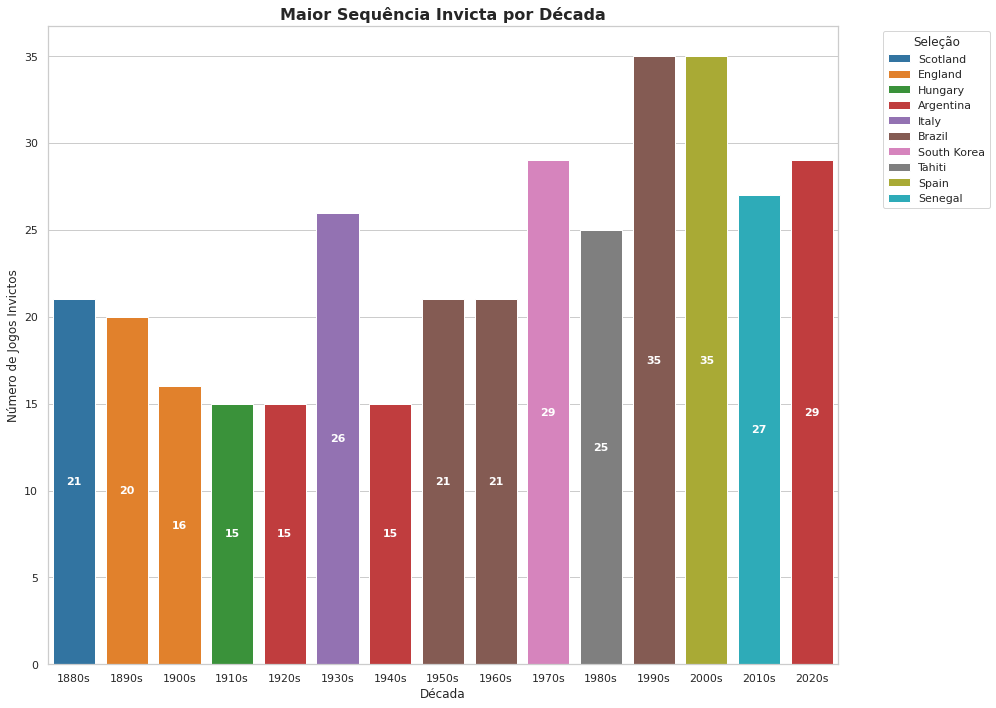

In [0]:
# Executa a query e carrega o resultado em um DataFrame do Spark
df_decade_unbeaten = spark.sql("""
  WITH all_matches AS (
    SELECT 
      match_id,
      match_date,
      'home' AS side,
      home_team AS team,
      away_team AS opponent,
      home_score AS goals_for,
      away_score AS goals_against
    FROM gold.match_performance

    UNION ALL

    SELECT 
      match_id,
      match_date,
      'away' AS side,
      away_team AS team,
      home_team AS opponent,
      away_score AS goals_for,
      home_score AS goals_against
    FROM gold.match_performance
  ),

  match_results AS (
    SELECT *,
      CASE 
        WHEN goals_for > goals_against THEN 'W'
        WHEN goals_for = goals_against THEN 'D'
        ELSE 'L'
      END AS result,
      CONCAT(FLOOR(YEAR(match_date) / 10) * 10, 's') AS decade
    FROM all_matches
  ),

  with_streaks AS (
    SELECT *,
      SUM(CASE WHEN result = 'L' THEN 1 ELSE 0 END)
        OVER (
          PARTITION BY team, decade 
          ORDER BY match_date 
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS loss_count
    FROM match_results
  ),

  streaks_grouped AS (
    SELECT
      team,
      decade,
      loss_count,
      COUNT(*) AS streak_length
    FROM with_streaks
    WHERE result IN ('W', 'D')
    GROUP BY team, decade, loss_count
    HAVING COUNT(*) >= 10
  ),

  max_streaks_per_team_decade AS (
    SELECT
      team,
      decade,
      MAX(streak_length) AS max_unbeaten_streak
    FROM streaks_grouped
    GROUP BY team, decade
  ),

  ranked_by_decade AS (
    SELECT *,
      ROW_NUMBER() OVER (
        PARTITION BY decade 
        ORDER BY max_unbeaten_streak DESC
      ) AS rank
    FROM max_streaks_per_team_decade
  )

  SELECT team, decade, max_unbeaten_streak
  FROM ranked_by_decade
  WHERE rank = 1
  ORDER BY decade
""")

# Converte para Pandas
pdf_decade_unbeaten = df_decade_unbeaten.toPandas()

# Garante a ordem cronológica das décadas
pdf_decade_unbeaten['decade'] = pd.Categorical(
    pdf_decade_unbeaten['decade'], 
    categories=sorted(pdf_decade_unbeaten['decade'].unique()), 
    ordered=True
)

# Define estilo do gráfico
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Cria gráfico de barras
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=pdf_decade_unbeaten,
    x="decade",
    y="max_unbeaten_streak",
    hue="team",
    dodge=False
)

# Adiciona valores nas barras
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height / 2),
            ha='center', va='center',
            color='white', fontsize=11, fontweight='bold'
        )

# Ajustes finais
plt.title("Maior Sequência Invicta por Década", fontsize=16, fontweight="bold")
plt.xlabel("Década", fontsize=12)
plt.ylabel("Número de Jogos Invictos", fontsize=12)
plt.legend(title="Seleção", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


%md
#### Destaques:

##### Top 10 Sequências Invictas da História:

- **Argélia** lidera o ranking com **42 jogos invictos**, enfrentando **30 adversários diferentes** — um feito notável que demonstra sua consistência e evolução no futebol africano, sobretudo em anos recentes.
- Em seguida aparecem:
  - **Itália** (37 jogos): impulsionada especialmente pela sequência que culminou no título da Euro 2020.
  - **Argentina** (36): sequência que incluiu o título da Copa América de 2021 e da Copa do Mundo de 2022.
  - **Espanha** e **Brasil** (ambos com 35): reflexo de gerações extremamente talentosas e dominantes em seus respectivos períodos.
- Também se destacam seleções como:
  - **Coreia do Sul**, **França**, **Colômbia**, **Senegal** e **Costa do Marfim** — mostrando que **longas sequências invictas não são exclusivas das potências tradicionais**, e que seleções de fora do eixo europeu-sul-americano também vêm demonstrando grande solidez e competitividade nos últimos anos.

Essa diversidade geográfica reforça a globalização do futebol e o fortalecimento técnico de seleções de diferentes continentes.

#####  Maiores Sequências Invictas por Década:

Desde o século XIX, diferentes seleções dominaram períodos específicos. Entre os principais destaques por década:

- **1880s** – **Escócia**: 21 jogos invictos em uma era em que o futebol ainda estava se organizando internacionalmente.
- **1950s, 1960s e 1990s** – **Brasil** se destaca em três décadas distintas, refletindo seu protagonismo histórico e a presença de gerações lendárias.
- **2000s** – **Espanha**: 35 jogos invictos em uma era de ouro, com títulos da Eurocopa (2008 e 2012) e Copa do Mundo (2010).
- **2010s** – **Senegal**: 27 jogos, confirmando o crescimento e a consolidação do futebol africano no cenário global.
- **2020s** – **Argentina**: 29 jogos invictos, reforçando sua força recente e o impacto de sua geração campeã mundial.

Esses dados mostram que o domínio no futebol de seleções **varia ao longo do tempo e entre continentes**, refletindo ciclos de renovação, evolução tática e momentos de excelência coletiva. O surgimento de seleções não tradicionais entre os líderes também indica uma **maior competitividade no cenário global**, com o futebol se tornando cada vez mais equilibrado.


### 5.6. **Qual seleção tem o maior número de jogos sem sofrer gols em toda a história?**  
Manter uma defesa sólida é um dos pilares do sucesso no futebol, sendo muitas vezes determinante em competições equilibradas. Uma equipe que consegue impedir seus adversários de marcar demonstra não apenas organização tática e eficiência defensiva, mas também um alto nível de concentração ao longo das partidas.

Nesta análise, buscou-se identificar as seleções que mais vezes conseguiram terminar jogos sem sofrer gols — também conhecidos como clean sheets. Esse indicador é uma métrica tradicionalmente utilizada para avaliar a consistência defensiva de uma equipe ao longo do tempo. A análise considerou tanto partidas amistosas quanto oficiais, abrangendo todo o histórico disponível no conjunto de dados, e revelou quais seleções conseguiram se destacar por sua solidez defensiva ao longo das décadas.

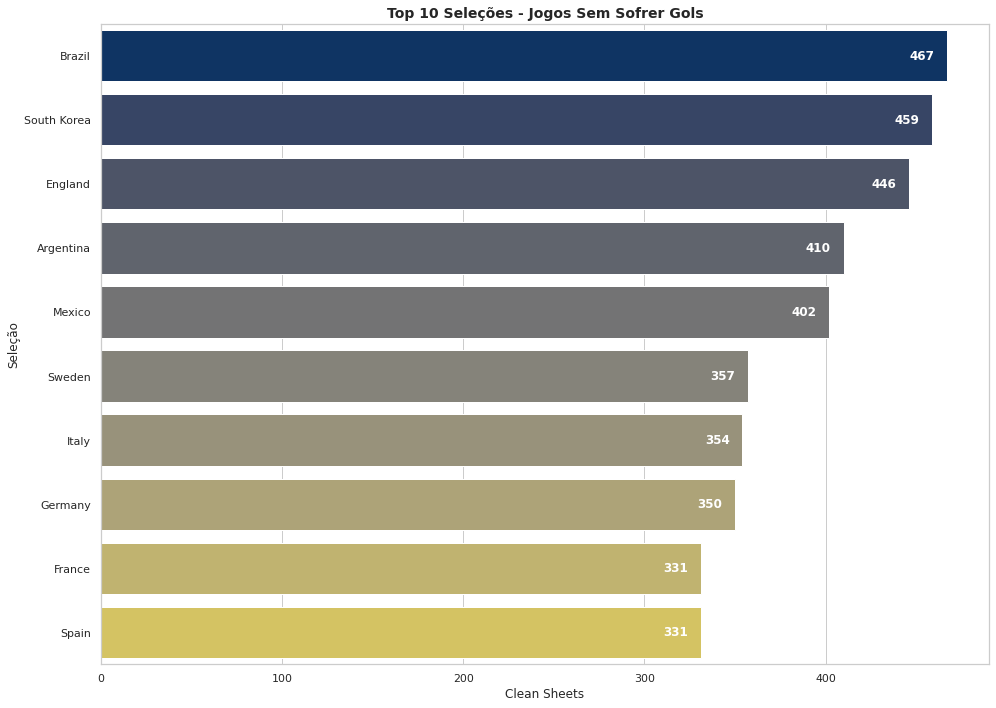

In [0]:
# Executa a query e carrega o resultado em um DataFrame do Spark
df_clean_sheets = spark.sql("""
  WITH home_clean_sheets AS (
    SELECT home_team AS team
    FROM gold.match_performance
    WHERE away_score = 0
  ),

  away_clean_sheets AS (
    SELECT away_team AS team
    FROM gold.match_performance
    WHERE home_score = 0
  ),

  all_clean_sheets AS (
    SELECT * FROM home_clean_sheets
    UNION ALL
    SELECT * FROM away_clean_sheets
  )

  SELECT team, COUNT(*) AS clean_sheets
  FROM all_clean_sheets
  GROUP BY team
  ORDER BY clean_sheets DESC
  LIMIT 10
""")

# Converte para Pandas e ordena por segurança
pdf_clean_sheets = df_clean_sheets.toPandas().sort_values(
    by="clean_sheets", ascending=False
)

# Chama a função de gráfico genérica
plot_horizontal_graph(
    df=pdf_clean_sheets,
    x_col="clean_sheets",
    y_col="team",
    label_col="clean_sheets",
    title="Top 10 Seleções - Jogos Sem Sofrer Gols",
    xlabel="Clean Sheets",
    ylabel="Seleção",
    palette="cividis",
    figsize=(14, 10),
  )


#### Destaques:

Os dados revelaram que o **Brasil** foi a seleção com o **maior número de partidas sem sofrer gols** na história, totalizando impressionantes **467 jogos**. Esse número refletiu não apenas a tradicional força ofensiva da equipe, mas também a **solidez de sua estrutura defensiva** ao longo das décadas, muitas vezes ofuscada por seus talentos no ataque.

Logo atrás, apareceu a **Coreia do Sul**, com **459 partidas sem sofrer gols** — um dado surpreendente que evidenciou a **consistência defensiva da seleção asiática** em sua longa trajetória internacional, especialmente no cenário continental.

Na sequência, completando o **top 10**, estavam seleções tradicionais como:

- **Inglaterra**
- **Argentina**
- **México**
- **Suécia**
- **Itália**
- **Alemanha**
- **França**
- **Espanha**

A **presença recorrente dessas equipes em grandes torneios internacionais** contribuiu para o alto número de clean sheets, já que disputaram mais partidas ao longo do tempo e contam com **elencos competitivos e estruturas defensivas consolidadas**.

Esses resultados reforçam que **a solidez defensiva é um elemento essencial** para o sucesso das seleções mais vitoriosas da história. Manter a consistência na defesa tem sido uma **característica marcante das equipes que alcançam longevidade e conquistas**, mostrando que atacar bem é importante — mas defender com eficiência é indispensável.


### 5.7. **Quais seleções tiveram os artilheiros mais consistentes e como o desempenho desses jogadores está relacionado com o sucesso da equipe?**  

Ao longo da história do futebol, grandes artilheiros marcaram época não apenas pelo número de gols, mas também pelo impacto direto que tiveram no desempenho de suas seleções. Esta análise busca identificar os jogadores mais consistentes em termos de gols marcados por partidas e relacionar essa produtividade individual com o sucesso coletivo de suas equipes.

Mais do que apenas contabilizar gols, o objetivo foi compreender como esses atletas influenciaram as vitórias, classificações e títulos de suas seleções. A presença de um artilheiro confiável pode representar um diferencial decisivo em partidas equilibradas e torneios de alto nível, servindo como pilar ofensivo e referência tática. Assim, ao observarmos os maiores goleadores e o contexto de seus desempenhos, foi possível traçar conexões entre brilho individual e conquistas coletivas, revelando como grandes talentos influenciaram diretamente a história do futebol de seleções.

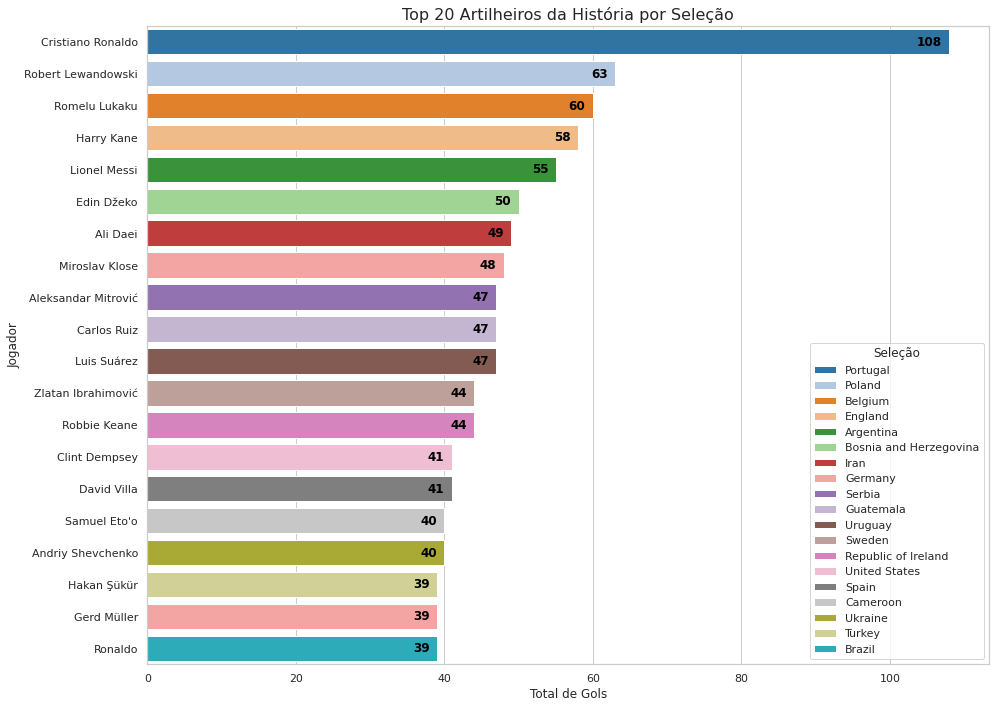

In [0]:
# Consulta SQL
top_scorers_pdf = spark.sql("""
    SELECT
        player_name,
        team_name,
        total_goals,
        matches_scored,
        max_goals_in_a_game,
        hat_tricks,
        penalty_goals,
        own_goals
    FROM gold.top_scorers
    ORDER BY total_goals DESC
    LIMIT 20
""").toPandas()

# Ordena para garantir ordem correta no gráfico
top_scorers_pdf = top_scorers_pdf.sort_values(
    by="total_goals", ascending=False
)

# Estilo e paleta
sns.set_style("whitegrid")
sns.set_palette("tab20")

# Cria figura
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=top_scorers_pdf,
    x="total_goals",
    y="player_name",
    hue="team_name",
    dodge=False
)

# Adiciona os valores nas barras
for i, row in top_scorers_pdf.iterrows():
    ax.text(
        row.total_goals - 1, i, row.total_goals,
        color="black", va="center", ha="right", fontweight="bold"
    )

# Títulos e ajustes
plt.title("Top 20 Artilheiros da História por Seleção", fontsize=16)
plt.xlabel("Total de Gols", fontsize=12)
plt.ylabel("Jogador", fontsize=12)
plt.legend(title="Seleção", loc="lower right")
plt.tight_layout()
plt.show()


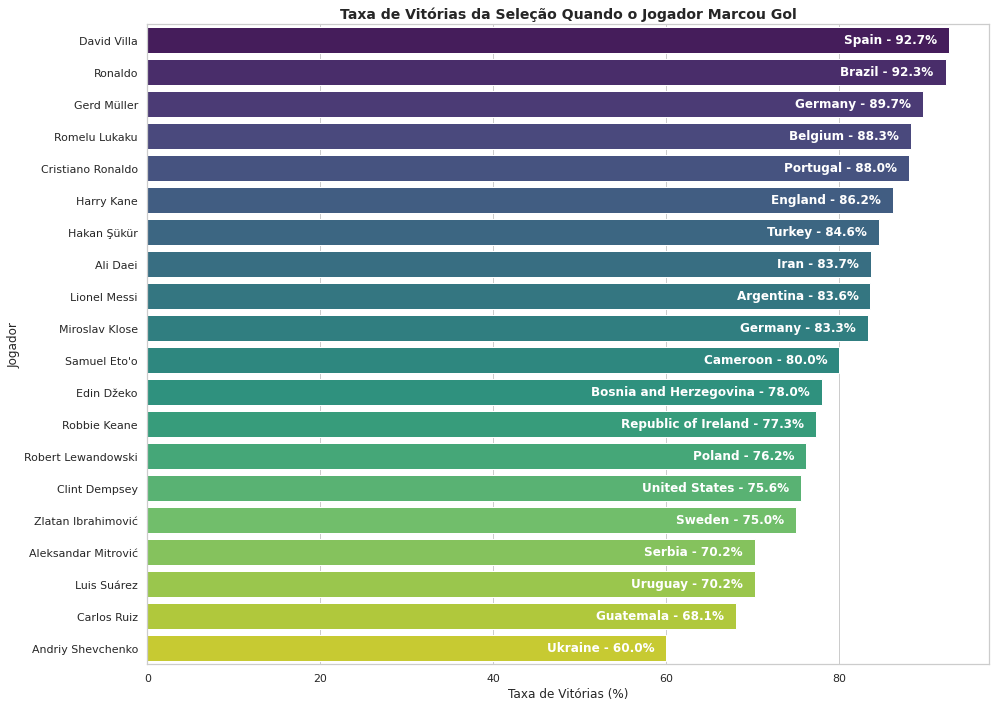

In [0]:
# Consulta SQL com CTEs
impact_scorers_pdf = spark.sql("""
    WITH top20_scorers AS (
        SELECT player_name, team_name
        FROM gold.top_scorers
        ORDER BY total_goals DESC
        LIMIT 20
    ),

    scorer_goals AS (
        SELECT
            gs.match_id,
            gs.scorer AS player_name,
            gs.scoring_team AS team_name
        FROM silver.goalscorers AS gs
        INNER JOIN top20_scorers AS t20
            ON gs.scorer = t20.player_name
    ),

    scorer_results AS (
        SELECT
            sg.player_name,
            sg.team_name,
            mp.match_id,
            CASE
                WHEN sg.team_name = mp.home_team AND mp.home_score > mp.away_score THEN 'Win'
                WHEN sg.team_name = mp.away_team AND mp.away_score > mp.home_score THEN 'Win'
                WHEN mp.home_score = mp.away_score THEN 'Draw'
                ELSE 'Loss'
            END AS result
        FROM scorer_goals AS sg
        INNER JOIN gold.match_performance AS mp
            ON sg.match_id = mp.match_id
    )

    SELECT
        player_name,
        team_name,
        COUNT(*) AS matches_with_goals,
        SUM(CASE WHEN result = 'Win' THEN 1 ELSE 0 END) AS wins_when_scored,
        SUM(CASE WHEN result = 'Draw' THEN 1 ELSE 0 END) AS draws_when_scored,
        SUM(CASE WHEN result = 'Loss' THEN 1 ELSE 0 END) AS losses_when_scored,
        ROUND(SUM(CASE WHEN result = 'Win' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1)
            AS win_rate_when_scored
    FROM scorer_results
    GROUP BY player_name, team_name
    ORDER BY win_rate_when_scored DESC
""").toPandas()

# Ordena os dados
impact_scorers_pdf = impact_scorers_pdf.sort_values(
    by="win_rate_when_scored", ascending=False
)

# Converte para float
impact_scorers_pdf["win_rate_when_scored"] = \
    impact_scorers_pdf["win_rate_when_scored"].astype(float)

# Cria coluna personalizada para os rótulos
impact_scorers_pdf["label"] = (
    impact_scorers_pdf["team_name"] + " - " +
    impact_scorers_pdf["win_rate_when_scored"].round(1).astype(str) + "%"
)

# Chamada da função
plot_horizontal_graph(
    df=impact_scorers_pdf,
    x_col="win_rate_when_scored",
    y_col="player_name",
    label_col="label",
    title="Taxa de Vitórias da Seleção Quando o Jogador Marcou Gol",
    xlabel="Taxa de Vitórias (%)",
    ylabel="Jogador",
    palette="viridis",
    figsize=(14, 10),
)

#### Destaques:

##### Artilheiros e Desempenho das Seleções: Gols que Conduzem a Vitórias

Esta análise revelou como o desempenho ofensivo dos **maiores artilheiros da história** influenciou diretamente os resultados de suas seleções — não apenas em termos de **gols marcados**, mas principalmente **em como esses gols se converteram em vitórias**.

#####  Gols Totais por Seleção

No primeiro gráfico, foram observados os jogadores com **maior número de gols marcados por suas seleções**:

- 🇵🇹 **Cristiano Ronaldo** – 108 gols (Portugal)
- 🇵🇱 **Robert Lewandowski** – 60 gols (Polônia)
- 🇦🇷 **Lionel Messi** – 58 gols (Argentina)
- 🇧🇪 **Romelu Lukaku** – 55 gols (Bélgica)

A presença desses atletas entre os maiores goleadores demonstrou que foram **peças-chave** para o ataque de suas seleções, sustentando o desempenho ofensivo ao longo dos anos.

**Interpretação**: Embora o volume de gols seja impressionante, ele **não garante o sucesso coletivo**. O verdadeiro impacto apareceu quando foi analisada a relação entre esses gols e os resultados das partidas.

##### Efetividade dos Gols no Desempenho das Seleções

O segundo gráfico mostrou a **taxa de vitórias das seleções quando o jogador marcou gol**, ou seja, o **quanto esses artilheiros influenciaram diretamente vitórias**:

- 🇪🇸 **Espanha com David Villa** – +92% de vitórias
- 🇧🇷 **Brasil com Ronaldo** – +92% de vitórias
- 🇩🇪 **Alemanha com Gerd Müller e Miroslav Klose** – acima de 88%
- 🇵🇹 **Portugal com Cristiano Ronaldo** – acima de 88%
- 🇧🇪 **Bélgica com Lukaku** – também acima de 88%

**Interpretação**: Esses dados refletem **seleções bem estruturadas**, com alto aproveitamento ofensivo e **capacidade de transformar gols em vitórias consistentes**.

Por outro lado:

- 🇺🇦 **Ucrânia com Shevchenko** – 60% de vitórias
- 🇬🇹 **Guatemala com Carlos Ruiz** – 68,1% de vitórias

**Interpretação**: Mesmo com artilheiros históricos, **o desempenho coletivo dessas seleções foi limitado**. Os gols marcados nem sempre resultaram em vitórias, evidenciando **desafios estruturais ou desequilíbrios táticos**.

**Conclusão**: Os dados reforçam que um grande artilheiro pode ser decisivo, mas seu impacto real depende de uma **estrutura coletiva eficiente** e de um time que saiba **capitalizar suas contribuições ofensivas**.


### 5.8. Quais seleções têm o melhor desempenho em disputas de pênaltis e como isso contribuiu para sua trajetória em torneios importantes?

As disputas de pênaltis representam um dos momentos mais dramáticos e decisivos do futebol, especialmente em torneios eliminatórios. Saber lidar com essa pressão é um diferencial que pode mudar o rumo de uma competição.

 Nesta análise, exploramos quais seleções se destacaram nesse aspecto, avaliando seu desempenho histórico em disputas de pênaltis com base na frequência de vitórias e taxa de aproveitamento. Ao observar quais equipes mais venceram nessas situações e com que eficiência o fizeram, foi possível entender o papel crucial dessas disputas na consolidação do sucesso de uma seleção em torneios internacionais.

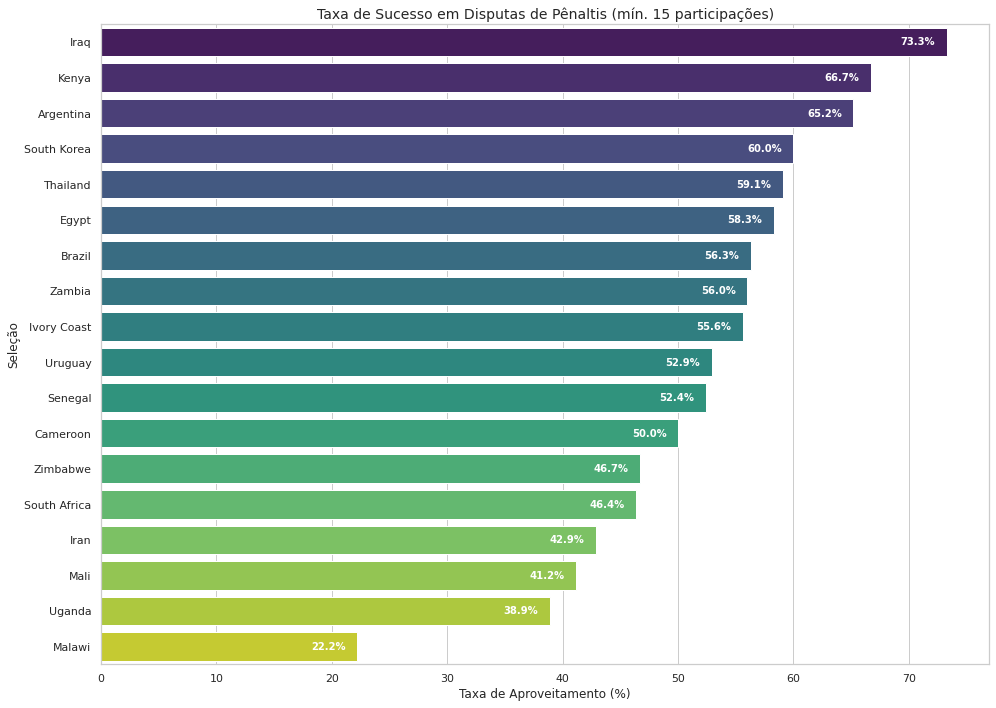

In [0]:
# Consulta SQL e conversão para Pandas
penalty_df = spark.sql("""
    SELECT 
        team,
        COUNT(CASE WHEN is_winner = 1 THEN 1 END) AS penalty_victories,
        COUNT(*) AS penalty_participations,
        ROUND(
            COUNT(CASE WHEN is_winner = 1 THEN 1 END) * 100.0 / COUNT(*),
            1
        ) AS penalty_win_rate
    FROM (
        SELECT 
            penalty_winner AS team,
            1 AS is_winner
        FROM gold.penalty_shootouts

        UNION ALL

        SELECT 
            penalty_loser AS team,
            0 AS is_winner
        FROM gold.penalty_shootouts
    ) AS all_penalty_matches
    GROUP BY team
    HAVING COUNT(*) >= 15
    ORDER BY penalty_win_rate DESC, penalty_victories DESC
""").toPandas()

sns.set_style("whitegrid")

# === Gráfico: 15 melhores seleções em pênaltis ===
top_penalties = penalty_df.sort_values(
    by="penalty_win_rate", ascending=False
)

plt.figure(figsize=(14, 10))
ax1 = sns.barplot(
    data=top_penalties,
    x="penalty_win_rate",
    y="team",
    palette="viridis"
)

for i, row in top_penalties.iterrows():
    ax1.text(
        row.penalty_win_rate - 1, i,
        f"{row.penalty_win_rate}%",
        va="center", ha="right",
        color="white", fontsize=10, fontweight="bold"
    )

plt.title(
    "Taxa de Sucesso em Disputas de Pênaltis (mín. 15 participações)",
    fontsize=14
)
plt.xlabel("Taxa de Aproveitamento (%)")
plt.ylabel("Seleção")
plt.tight_layout()
plt.show()



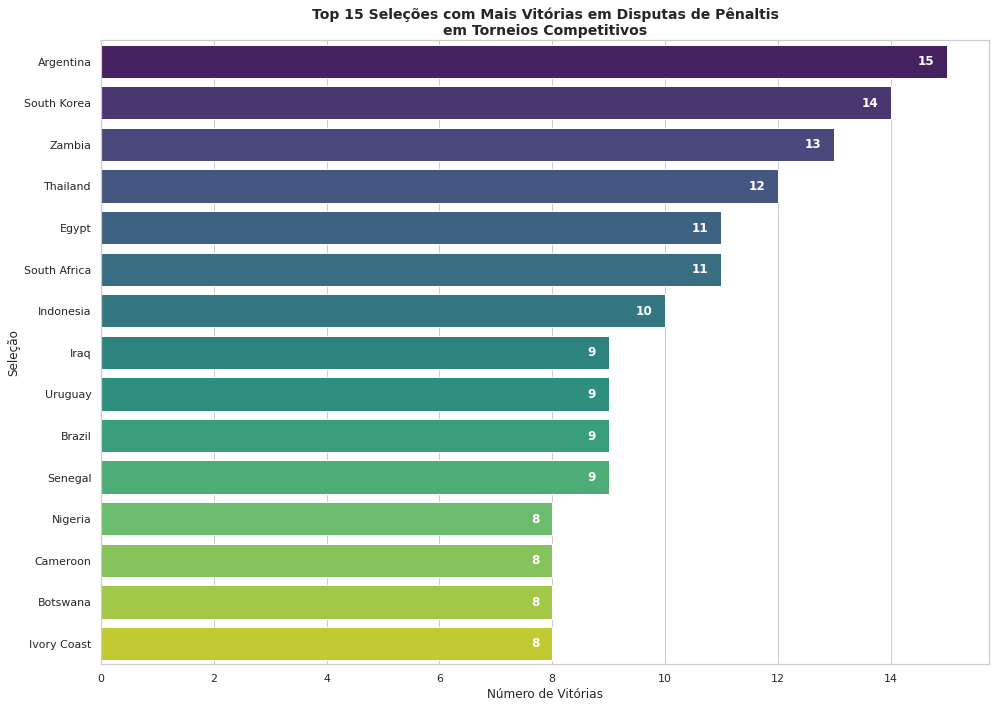

In [0]:
# Carrega as tabelas gold do Spark para Pandas
penalty_shootouts_df = spark.table("gold.penalty_shootouts").toPandas()
match_performance_df = spark.table("gold.match_performance").toPandas()

# Filtra apenas disputas de pênaltis em jogos competitivos
competitive_matches = match_performance_df[
    ~match_performance_df["tournament"]
     .str.lower()
     .str.contains("friendly")
]

competitive_penalties = penalty_shootouts_df.merge(
    competitive_matches[["match_id", "tournament"]],
    on="match_id",
    how="inner"
)

# Conta as vitórias por seleção
top_penalty_winners = (
    competitive_penalties["penalty_winner"]
    .value_counts()
    .reset_index()
    .rename(columns={
        "index": "team",
        "penalty_winner": "competitive_penalty_wins"
    })
    .head(15)
)

# Chamada da função genérica
plot_horizontal_graph(
    df=top_penalty_winners,
    x_col="competitive_penalty_wins",
    y_col="team",
    label_col="competitive_penalty_wins",
    title="Top 15 Seleções com Mais Vitórias em Disputas de Pênaltis\nem Torneios Competitivos",
    xlabel="Número de Vitórias",
    ylabel="Seleção",
    palette="viridis",
    figsize=(14, 10)
)


#### Destaques:
##### Análise do Desempenho das Seleções em Disputas de Pênaltis

Nesta seção, analisamos o desempenho das seleções nacionais em **disputas de pênaltis**, com base em três perspectivas complementares:

- Aproveitamento (eficiência)
- Ineficiência
- Volume de vitórias em torneios competitivos

Os dados foram extraídos da tabela `gold.penalty_shootouts`, cruzados com informações da `match_performance`, considerando **apenas partidas entre seleções masculinas principais com decisão por pênaltis**.

##### Top 15 Seleções com Melhor Aproveitamento em Disputas de Pênaltis

O primeiro gráfico destacou as seleções com as **maiores taxas de sucesso** nas cobranças:

- Iraque – 73,3%
- Quênia – 66,7%
- Argentina – 65,2%
- Tailândia, Egito, Coreia do Sul
- Brasil – 56,3%

**Interpretação:** Algumas seleções com menor tradição, como Zâmbia e Egito, se destacaram positivamente.  
No entanto, altas taxas de aproveitamento podem estar associadas a um número reduzido de disputas, limitando a comparação direta com seleções mais frequentes em fases eliminatórias.

##### Seleções com Mais Vitórias em Disputas de Pênaltis (Torneios Oficiais)

O segundo gráfico considerou **apenas decisões por pênaltis em torneios oficiais**:

- Argentina – 15 vitórias (líder isolada)
- Coreia do Sul – 14
- Zâmbia – 13
- Brasil, Uruguai, Senegal e Iraque – 9 vitórias cada

**Interpretação:** Esta métrica revelou não só a eficiência, mas também a **frequência com que uma seleção chegou a momentos decisivos**.  
O caso da Argentina é emblemático: alto volume e ótimo aproveitamento, tornado o país uma potência em disputas por pênaltis.

##### Considerações

- A Argentina foi a seleção com melhor desempenho geral, unindo eficiência e constância em momentos decisivos.
- O Brasil, apesar de sua tradição, apresentou desempenho apenas mediano, tanto em aproveitamento quanto em número de vitórias.
- Zâmbia, Tailândia e Coreia do Sul surpreenderam com bons resultados em contextos menos esperados.
- As penalidades são um componente de alta imprevisibilidade no futebol, exigindo qualidade técnica, preparo psicológico e experiência histórica para maximizar as chances de sucesso.


### 6. Solução do problema e considerações finais:

A análise do desempenho histórico das seleções nacionais masculinas revelou um **mosaico rico e multifacetado do futebol internacional**.  
Ao explorar diferentes aspectos — como **vitórias**, **aproveitamento de pontos**, **desempenho contra grandes seleções**, **invencibilidade**, **solidez defensiva**, **impacto dos artilheiros** e **eficiência em disputas de pênaltis** — foi possível identificar **padrões consistentes** e **trajetórias distintas de sucesso** entre as seleções analisadas.

#### Principais Destaques

- **Brasil** se consolidou como a seleção com o **maior número de vitórias** e também com o **maior volume de partidas sem sofrer gols**, demonstrando uma combinação marcante entre tradição ofensiva e solidez defensiva.

- **Argentina** destacou-se por sua **eficiência em momentos decisivos**, liderando com folga as **vitórias em disputas de pênaltis** e mantendo um desempenho recente altamente consistente.

- **Alemanha, Itália, França, Espanha e Inglaterra** mostraram **constância histórica**, presença frequente em grandes torneios e destaque em múltiplas métricas, refletindo a força e o peso de suas camisas ao longo das décadas.

- **Coreia do Sul, Zâmbia, Senegal e Egito** surpreenderam com **regularidade em aspectos específicos**, evidenciando como o futebol global se tornou **mais competitivo e descentralizado**.

#### Mas afinal: qual é a melhor seleção de todos os tempos?

Com base nos dados analisados, o **Brasil** se destacou como a **seleção mais dominante da história do futebol masculino**.  
A liderança em número de vitórias, o **recorde absoluto de partidas sem sofrer gols**, o **alto aproveitamento de pontos ao longo das décadas** e a presença constante entre os melhores em praticamente todas as métricas indicam uma **superioridade sustentada no tempo**.

Embora outras seleções tenham vivido momentos de glória marcantes — como a eficiência decisiva da Argentina ou o pragmatismo vitorioso da Alemanha —, **nenhuma equipe combinou com tanta amplitude os elementos de longevidade, consistência, versatilidade tática e excelência técnica quanto a seleção brasileira**.

**Conclusão:** os dados sugerem que **o Brasil é, com razoável margem, a melhor seleção nacional masculina da história do futebol**.

---

#### Considerações finais:

Nesse MVP foi possível desenvolver diversos conceitos de Engenharia de Dados abordados nas disciplinas da Sprint. Alguns pontos merecem ser destacados em relação a todo esse desenvolvimento:

- Com base nos dados disponíveis, foi possível responder com detalhes todas as questões levantadas. De forma a enriquecer a análise, outras métricas poderiam ser adicionadas e ficam como sugestão para trabalhos futuros: desempenho das seleções em competições específicas, desempenho em relação aos adversários de confederação, gols marcados em momentos decisivos do jogo, entre outras. 

- Devido a ausência de dados informativos a respeito dos títulos conquistados pelas equipes, não foi possível utilizar uma métrica com base nesses dados. Até seria possível deduzir a partir das tabelas de resultados, mas foi verificado durante a produção do trabalho que as partidas finais dos torneios não estavam claramente definidas e uma dedução por outro dado não seria possível. Uma sugestão de trabalho futuro seria a incorporação desses dados de forma a enriquecer a análise;

- A plataforma Databricks Community foi muito útil no desenvolvimento do trabalho devido à ausência de custo para sua utilização, em comparação com outras plataformas em nuvem no mercado. Entretanto, a limitação de utilização de cluster por tempo definido gerou um desgaste na produção do trabalho devido à necessidade constante de carga de todas as tabelas no ambiente da plataforma.


